<a href="https://colab.research.google.com/github/paolapt/8puzzle/blob/main/GenAlgv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
### FC 3: Genetic Algorithm in Python

import random
import matplotlib.pyplot as plt

#problem Setup: System Model: A distributed system with 5 nodes, each with different capacities: (Node Constraints)
nodes = {
    1: {'cpu': 8, 'mem': 16, 'bw': 100},
    2: {'cpu': 4, 'mem': 32, 'bw': 50},
    3: {'cpu': 16, 'mem': 8, 'bw': 200},
    4: {'cpu': 12, 'mem': 24, 'bw': 150},
    5: {'cpu': 6, 'mem': 12, 'bw': 80}
}

#additional constraints: Maximum Resource Usage Per Node: CPU 80%, memory 90%, bandwidth 75%
cpu_limit = 0.8
mem_limit = 0.9
bw_limit = 0.75

#tasks: 10 computational tasks, each with: CPU, memory, and bandwidth requirements. Estimated execution time on each node.
tasks = [
    {'cpu': 2, 'mem': 2, 'bw': 20, 'exec_time': [10, 15, 12, 11, 14]},
    {'cpu': 2, 'mem': 4, 'bw': 10, 'exec_time': [30, 20, 14, 13, 17]},
    {'cpu': 1, 'mem': 1, 'bw': 5,  'exec_time': [8, 10, 30, 6, 9]},
    {'cpu': 2, 'mem': 3, 'bw': 15, 'exec_time': [14, 18, 16, 15, 19]},
    {'cpu': 1, 'mem': 2, 'bw': 8,  'exec_time': [9, 13, 11, 10, 12]},
    {'cpu': 3, 'mem': 4, 'bw': 20, 'exec_time': [20, 25, 22, 21, 23]},
    {'cpu': 2, 'mem': 3, 'bw': 10, 'exec_time': [21, 17, 13, 12, 16]},
    {'cpu': 1, 'mem': 1, 'bw': 5,  'exec_time': [5, 6, 4, 4, 10]},
    {'cpu': 2, 'mem': 4, 'bw': 18, 'exec_time': [15, 19, 16, 19, 18]},
    {'cpu': 2, 'mem': 5, 'bw': 25, 'exec_time': [40, 28, 24, 23, 27]},
]

num_tasks = len(tasks) #total number of tasks (in our case, 10, but if needed yoy can add / erase tasks)
num_nodes = len(nodes) #total number of nodes
pop_size = 20 #number of schedules per generation
generations = 1000 #number of generations in total
mutation_rate = 0.2 #probability of a schedule randomly switching the node for a task
utilization_scores = []  #for storing score of best individuals
makespanss = []
fitnesses = []

#obj maximize resources, minimize total time
#generate a valid individual schedule
def generate_individual(): #each individual represents a schedule (task-to-node mapping).
    for attempt in range(500):
        individual = []
        for task in range(num_tasks):
            node_index = random.randint(0, num_nodes - 1) #we randomly choose a node for the current task
            individual.append(node_index) #add the task to the node
        if is_valid(individual): #check if the schedule is valid, otherwise keep generating randomly
            return individual
    raise RuntimeError("Could not create a valid schedule in 500 attempts :( sorry") #just in case we fail to randomly generate after the set number of attempts

#check if a schedule is within allowed resource limits
def is_valid(schedule):
    usage = {}
    for i in range(num_nodes): #initiating the usage per node
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task_index in range(num_tasks): #here we will be accumulating the resource usage for each one of the nodes
        node_index = schedule[task_index]
        task = tasks[task_index]
        usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
        usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
        usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']

    for i in range(num_nodes): #check if any of the nodes exceeds its limit
        node = nodes[i + 1]
        if usage[i]['cpu'] > node['cpu'] * cpu_limit:
            return False
        if usage[i]['mem'] > node['mem'] * mem_limit:
            return False
        if usage[i]['bw'] > node['bw'] * bw_limit:
            return False
    return True

#evaluate how good a schedule is (lower is better)
def fitness(schedule):
    if not is_valid(schedule):
        return float('inf') #invalid schedules have an infinite value (so that they get the worst score)

    finish_times = [0] * num_nodes #task execution time per node
    usage = {} #resetting usage
    for i in range(num_nodes):
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task_index in range(num_tasks): #assign tasks to calculate time and usage
        node_index = schedule[task_index]
        task = tasks[task_index]

        finish_times[node_index] = finish_times[node_index] + task['exec_time'][node_index]
        usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
        usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
        usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']

    makespan = max(finish_times) #time for last task to finish running

    utilization_total = 0
    for i in range(num_nodes): #we get the avg utilization across all nodes
        node = nodes[i + 1]
        cpu_u = usage[i]['cpu'] / (node['cpu'] * cpu_limit)
        mem_u = usage[i]['mem'] / (node['mem'] * mem_limit)
        bw_u  = usage[i]['bw']  / (node['bw'] * bw_limit)
        utilization_total = utilization_total + (cpu_u + mem_u + bw_u) / 3

    utilization_avg = utilization_total / num_nodes
    return makespan - utilization_avg

#calculate utilization score of a schedule
def utilization_score(schedule):
    usage = {}
    for i in range(num_nodes):
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task_index in range(num_tasks):
        node_index = schedule[task_index]
        task = tasks[task_index]

        usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
        usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
        usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']

    total_util = 0
    for i in range(num_nodes):
        node = nodes[i + 1]
        cpu_u = usage[i]['cpu'] / (node['cpu'] * cpu_limit)
        mem_u = usage[i]['mem'] / (node['mem'] * mem_limit)
        bw_u  = usage[i]['bw']  / (node['bw'] * bw_limit)
        total_util = total_util + (cpu_u + mem_u + bw_u) / 3

    return total_util / num_nodes

#return fitness score (for sorting so we can figure out which ones to remove)
def get_fitness(individual):
    return fitness(individual)

#select top n individuals - select schedules with better fitness for reproduction.
def select(population, top_n=6):
    sorted_population = sorted(population, key=get_fitness)
    return sorted_population[:top_n]

#crossover: exchange task assignments between two schedules (combine two parents to make a child)
def crossover(parent1, parent2):
    point = random.randint(1, num_tasks - 2)
    part1 = []
    part2 = []
    for i in range(point):
        part1.append(parent1[i])
    for i in range(point, num_tasks):
        part2.append(parent2[i])
    return part1 + part2

#mutate: randomly reassign a task to a different node.
def mutate(schedule):
    if random.random() < mutation_rate:
        index = random.randint(0, num_tasks - 1)
        new_node = random.randint(0, num_nodes - 1)
        schedule[index] = new_node
    return schedule

#print all schedules in a generation
def print_population(population, title="Population"):
    print(f"\n--- {title} ---")
    for i in range(len(population)):
        fit = fitness(population[i])
        print(f"Schedule {i + 1}: {population[i]}, Fitness: {fit:.2f}")

    best = population[0]
    worst = population[0]
    for ind in population:
        if fitness(ind) < fitness(best):
            best = ind
        if fitness(ind) > fitness(worst):
            worst = ind

    print(f"\n>>> Best: {best}, Fitness: {fitness(best):.2f}")
    print(f">>> Worst: {worst}, Fitness: {fitness(worst):.2f}")

#start the genetic algorithm - initial population of valid schedules
population = []
while len(population) < pop_size:
    try:
        individual = generate_individual()
        population.append(individual)
    except RuntimeError:
        break


print_population(population, "Initial generation:") #print initial generation
best_solution = None #intiializing
best_fitness = float('inf') #start with the worst possible fitness so that we can see improvement (since fitness will always be higher than negative infinity)


total_generations = generations #run for number of generations chosen

for generation in range(total_generations):
    #print(generation)
    new_population = select(population, top_n=10) #we choose how many we wanna keep out of the initial population

    while len(new_population) < pop_size: #randomly pick two parents from the pool of selected scedules
        parent1 = random.choice(new_population)
        parent2 = random.choice(new_population)
        child = crossover(parent1, parent2) #make a child (combine parents)
        child = mutate(child) #change with a small probability
        if is_valid(child): #only keep if schedule is valid
            new_population.append(child)

    population = new_population #replace population with new one


# tracking best solutions
    current_best = population[0]
    for ind in population:
        if fitness(ind) < fitness(current_best):
            current_best = ind

    current_fitness = fitness(current_best)

    if current_fitness < best_fitness: #for updating the overall best one
        best_fitness = current_fitness
        best_solution = current_best
        util = utilization_score(best_solution)
        utilization_scores.append(util)

        finish_times = [0] * num_nodes
        for task_index, node_index in enumerate(best_solution):
          finish_times[node_index] += tasks[task_index]['exec_time'][node_index]
        current_makespan = max(finish_times) #time to finish all tasks

        makespanss.append(current_makespan)
        fitnesses.append(best_fitness)

        ####optimization goals:
          #Primary: Minimize the total makespan (time to complete all tasks).
          #Secondary: Maximize resource utilization across nodes.
        print(f"\n>>> Generation {generation+1}: Current best fitness = {best_fitness:.2f}")
        print(f"Makespan: {current_makespan}")
        print(f"Utilization score: {util:.4f}")

    # DEBUG if generation == 1 or generation == 2 or  generation == 3 :
    #   util = utilization_score(current_best)
    #   finish_times = [0] * num_nodes
    #   for task_index, node_index in enumerate(current_best):
    #       finish_times[node_index] += tasks[task_index]['exec_time'][node_index]
    #   current_makespan = max(finish_times)
    #   print_population(population, f"Generation {generation}")


#print final generation
print_population(population, f"Final generation {generations}")

#print final best solution
if best_solution:
    print("\nBest schedule found:")
    for i in range(num_tasks):
        print(f"Task {i+1} → Node {best_solution[i] + 1}")
else:
    print("\nNo valid schedule found :(!!!")


--- Initial generation: ---
Schedule 1: [0, 4, 3, 2, 3, 2, 0, 1, 3, 3], Fitness: 57.59
Schedule 2: [0, 3, 3, 0, 1, 2, 4, 4, 1, 0], Fitness: 63.53
Schedule 3: [2, 0, 0, 3, 2, 3, 3, 2, 0, 4], Fitness: 52.60
Schedule 4: [0, 2, 1, 4, 4, 3, 1, 2, 3, 0], Fitness: 49.54
Schedule 5: [0, 2, 4, 3, 0, 3, 3, 2, 3, 0], Fitness: 66.62
Schedule 6: [1, 3, 0, 3, 1, 0, 3, 3, 0, 2], Fitness: 43.56
Schedule 7: [2, 4, 2, 0, 1, 3, 0, 1, 2, 3], Fitness: 57.57
Schedule 8: [3, 0, 4, 1, 4, 3, 0, 2, 3, 4], Fitness: 50.56
Schedule 9: [2, 4, 0, 1, 3, 3, 0, 1, 4, 3], Fitness: 53.55
Schedule 10: [3, 3, 1, 4, 4, 0, 1, 3, 3, 0], Fitness: 59.56
Schedule 11: [3, 1, 4, 3, 2, 2, 3, 2, 0, 0], Fitness: 54.59
Schedule 12: [3, 2, 3, 3, 0, 4, 3, 3, 0, 0], Fitness: 63.59
Schedule 13: [3, 4, 0, 2, 0, 3, 0, 1, 3, 4], Fitness: 50.57
Schedule 14: [3, 2, 3, 0, 1, 4, 2, 3, 0, 1], Fitness: 40.52
Schedule 15: [0, 2, 1, 0, 4, 4, 3, 2, 3, 1], Fitness: 37.52
Schedule 16: [4, 2, 2, 0, 3, 1, 3, 3, 4, 3], Fitness: 48.54
Schedule 17: [3, 2, 

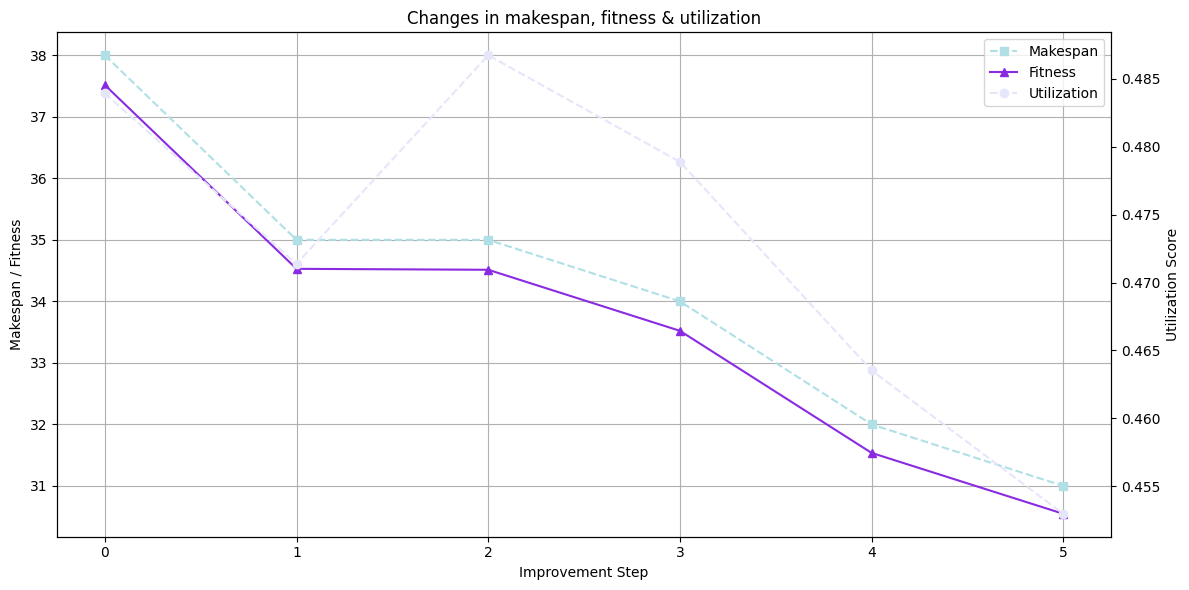

In [8]:
import matplotlib.pyplot as plt

if utilization_scores and makespanss and fitnesses:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    #primary y axis (left for fitness and makespan because they're similar)
    ax1.plot(makespanss, marker='s', linestyle='--', color='powderblue', label='Makespan')
    ax1.plot(fitnesses, marker='^', linestyle='-', color='blueviolet', label='Fitness')
    ax1.set_xlabel("Improvement Step")
    ax1.set_ylabel("Makespan / Fitness")
    ax1.grid(True)

    #secondary y-axis (right) for utilization
    ax2 = ax1.twinx()
    ax2.plot(utilization_scores, marker='o', linestyle='--', color='lavender', label='Utilization')
    ax2.set_ylabel("Utilization Score")

    #combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title("Changes in makespan, fitness & utilization")
    plt.tight_layout()
    plt.show()

In [9]:
def firstfit():
    schedule = []
    usage = {}
    for i in range(num_nodes):
        usage[i] = {'cpu': 0, 'mem': 0, 'bw': 0}

    for task in tasks:
        assigned = False #start with none of the tasks assigned
        for node_index in range(num_nodes):
            node = nodes[node_index + 1]
            cpu_ok = usage[node_index]['cpu'] + task['cpu'] <= node['cpu'] * cpu_limit #check if it meets each one of the limits
            mem_ok = usage[node_index]['mem'] + task['mem'] <= node['mem'] * mem_limit
            bw_ok  = usage[node_index]['bw']  + task['bw']  <= node['bw'] * bw_limit
            if cpu_ok and mem_ok and bw_ok: #if all 3 restrictions are met, then we can add our task to the node
                usage[node_index]['cpu'] = usage[node_index]['cpu'] + task['cpu']
                usage[node_index]['mem'] = usage[node_index]['mem'] + task['mem']
                usage[node_index]['bw']  = usage[node_index]['bw']  + task['bw']
                schedule.append(node_index)
                assigned = True
                break
        if not assigned:
            print("Task could not be assigned!!!")
            schedule.append(-1)  # here -1 means we couldnt find a node for our task
    return schedule


In [10]:
ffsched = firstfit()

if -1 not in ffsched: #if we dont have a -1, then a valid schedule was found for our tasks
    fit = fitness(ffsched)
    util = utilization_score(ffsched)
    print("\n>>> First fit schedule")
    for i in range(num_tasks):
        print(f"Task {i+1} → Node {ffsched[i] + 1}")
    print(f"Fitness: {fit:.2f}")
    print(f"Utilization: {util:.4f}")
else:
    print("\n Couldn't assign all tasks with this method!!):")



>>> First fit schedule
Task 1 → Node 1
Task 2 → Node 1
Task 3 → Node 1
Task 4 → Node 2
Task 5 → Node 1
Task 6 → Node 3
Task 7 → Node 3
Task 8 → Node 2
Task 9 → Node 4
Task 10 → Node 4
Fitness: 56.57
Utilization: 0.4349
